<a href="https://colab.research.google.com/github/dipanjanS/data_science_for_all/blob/master/gde_tf_serve_vision/tensorflow_serving/Model_Training_Prototypes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build and Deploy Deep Learning Vision Models with TensorFlow 

![](https://miro.medium.com/max/2275/1*-uxB0EnnMX-rAoTFp8xZew.png)

Thanks to faster compute, better storage and easy to use software, deep learning based solutions are definitely seeing the light of the day coming out from the proof-of-concept tunnel into the real-world! We are seeing widespread adoption of deep learning models across diverse domains in the industry including healthcare, finance, retail, tech, logistics, food-tech, agriculture amongst many others! Considering the fact that deep learning models are resource hungry and often compute-heavy, we need to pause for a moment and think about model inference and serving times, when consumed by end-users.

We will be covering the following topics in this tutorial:

- Main Objective — Building an Apparel Classifier
- Training a simple CNN Model
- Fine-tuning a pre-trained ResNet-50 CNN Model
- TensorFlow Serving Overview
- Saving models for TensorFlow Serving
- Serving models with CPU Inference
- Serving models with Docker for GPU Inference
- Bonus: Building an Apparel Classifier API with Flask & TensorFlow Serving

<div style="text-align: right"><i><font size="2">Tutorial by: <a href="https://www.linkedin.com/in/dipanzan" target="_parent">Dipanjan (DJ) Sarkar</a></font></i></div>

# Load Dependencies 

While the original article for this tutorial was written on TensorFlow 1.14, it leverages the __`tf.keras`__ API style and hence it is recommended you try this out on TensorFlow 2.0

In [1]:
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm

tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

%matplotlib inline

1.14.0


# Main Objective — Building & Deploying an Apparel Classifier

We will keep things simple here with regard to the key objective. We will build a simple apparel classifier by training models on the very famous [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset based on Zalando’s article images — consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. The idea is to classify these images into an apparel category amongst 10 categories on which we will be training our models on.

Here's an example how the data looks (each class takes three-rows):

<table>
  <tr><td>
    <img src="https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. You can access the Fashion MNIST directly from TensorFlow.

__Note:__ Although these are really images, they are loaded as NumPy arrays and not binary image objects.

We will build the following two deep learning CNN (Convolutional Neural Network) classifiers in this article before focusing on model serving.
- A simple CNN trained from scratch
- Fine-tuning a pre-trained ResNet-50 CNN

The intent of this article is to focus more on deployment and serving aspects hence we won’t spend a whole lot of time talking about model architectures or training and fine-tuning. Feel free to check out a brief on CNNs if necessary towards the very end of [this article](https://towardsdatascience.com/ai-powered-search-for-extra-terrestrial-intelligence-analyzing-radio-telescopic-data-c9e46741041) but we will add it in this notebook also in the following section for your ease of access. My testbed for this article was a [Google Cloud Platform Deep Learning VM](https://cloud.google.com/deep-learning-vm/) with a NVIDIA Tesla T4 which makes it really easy to carry out experiments on the cloud!

![](https://miro.medium.com/max/570/1*hDu3dNc7AN2rOX-fpxr_wA.png)

# Load Dataset
Here we will leverage an out of the box dataset since the intent of this tutorial is to showcase model serving more than model architecture, training and evaluation. However we will cover these steps also to a good extent.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


Train_images.shape: (60000, 28, 28), of uint8
Test_images.shape: (10000, 28, 28), of uint8


Based on what we mentioned earlier, we have 60000 training and 10000 test images of size 28x28. We will now start training our deep learning models.

# Brief on Convolutional Neural Networks

The most popular deep learning models leveraged for computer vision problems are convolutional neural networks (CNNs)!

![](https://miro.medium.com/max/2000/1*rO65zGl2k7xVBRhJZggQSA.gif)

CNNs typically consist of multiple convolution and pooling layers which help the deep learning model in automatically extracting relevant features from visual data like images. Due to this multi-layered architecture, CNNs learn a robust hierarchy of features, which are spatial, rotation, and translation invariant.

![](https://miro.medium.com/max/1456/1*NKL76WYQwH5LuqyaQTjBNw.png)

The key operations in a CNN model are depicted in the figure above. Any image can be represented as a tensor of pixel values. The convolution layers help in extracting features from this image (forms feature maps). Shallower layers (closer to the input data) in the network learn very generic features like edges, corners and so on. Deeper layers in the network (closer to the output layer) learn very specific features pertaining to the input image. The following graphic helps summarize the key aspects of any CNN model.

![](https://miro.medium.com/max/1366/1*nCQeDMjKoTGst1RiCDo9Fw.png)

We will be building a CNN from scratch as well as leverage the power of transfer learning, where we use pre-trained deep learning CNNs in this tutorial. 

# Training a simple CNN Model from Scratch

In this section, we will train a basic 2-layer CNN model from scratch.

## Reshaping Image Data for Modeling

We do need to reshape our data before we train our model. Here we will work on grayscale, 1-channel images (image pixel tensors)

In [3]:
# reshape for feeding into the model
train_images_gr = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images_gr = test_images.reshape(test_images.shape[0], 28, 28, 1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_gr.shape, train_images_gr.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_gr.shape, test_images_gr.dtype))


Train_images.shape: (60000, 28, 28, 1), of uint8
Test_images.shape: (10000, 28, 28, 1), of uint8


## Visualize sample images

['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal']


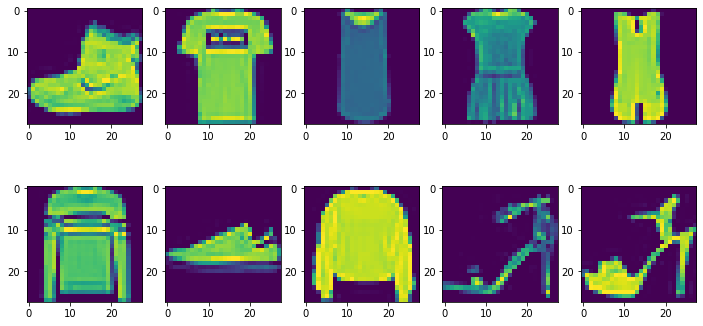

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
ax[0, 0].imshow(train_images_gr[0].reshape(28,28))
ax[0, 1].imshow(train_images_gr[1].reshape(28,28))
ax[0, 2].imshow(train_images_gr[2].reshape(28,28))
ax[0, 3].imshow(train_images_gr[3].reshape(28,28))
ax[0, 4].imshow(train_images_gr[4].reshape(28,28))
ax[1, 0].imshow(train_images_gr[5].reshape(28,28))
ax[1, 1].imshow(train_images_gr[6].reshape(28,28))
ax[1, 2].imshow(train_images_gr[7].reshape(28,28))
ax[1, 3].imshow(train_images_gr[8].reshape(28,28))
ax[1, 4].imshow(train_images_gr[9].reshape(28,28))

print([class_names[i] for i in train_labels[:10]])

## Build CNN Model Architecture

We will now build our basic 2-layer CNN model architecture.

In [6]:
INPUT_SHAPE = (28, 28, 1)

def create_cnn_architecture_model1(input_shape):
    inp = keras.layers.Input(shape=input_shape)

    conv1 = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='same')(inp)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                   activation='relu', padding='same')(pool1)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    flat = keras.layers.Flatten()(pool2)

    hidden1 = keras.layers.Dense(256, activation='relu')(flat)
    drop1 = keras.layers.Dropout(rate=0.3)(hidden1)

    out = keras.layers.Dense(10, activation='softmax')(drop1)

    model = keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    return model

In [7]:
model = create_cnn_architecture_model1(input_shape=INPUT_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               401664

## Model Training

Let’s train our model for 10 epochs and look at the performance.

In [8]:
EPOCHS = 10
train_images_scaled = train_images_gr / 255.
model.fit(train_images_scaled, train_labels, validation_split=0.1, epochs=EPOCHS)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 7s 122us/sample - loss: 0.4614 - acc: 0.8323 - val_loss: 0.3462 - val_acc: 0.8725
Epoch 2/10
54000/54000 [==============================] - 5s 86us/sample - loss: 0.3073 - acc: 0.8892 - val_loss: 0.2825 - val_acc: 0.8950
Epoch 3/10
54000/54000 [==============================] - 5s 87us/sample - loss: 0.2633 - acc: 0.9029 - val_loss: 0.2749 - val_acc: 0.9002
Epoch 4/10
54000/54000 [==============================] - 5s 86us/sample - loss: 0.2327 - acc: 0.9146 - val_loss: 0.2390 - val_acc: 0.9113
Epoch 5/10
54000/54000 [==============================] - 5s 86us/sample - loss: 0.2072 - acc: 0.9227 - val_loss: 0.2268 - val_acc: 0.9178
Epoch 6/10
54000/54000 [==============================] - 5s 85us/sample - loss: 0.1862 - acc: 0.9320 - val_loss: 0.2252 - val_acc: 0.9120
Epoch 7/10
54000/54000 [==============================] - 5s 86us/sample - loss: 0.1702 - acc: 0.9361 - val_loss: 0.

## Save Model Weights

In [12]:
import os

if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
    
model.save_weights(filepath='model_weights/cnn_model1_wt.h5', overwrite=True)

## Build Model Architecture and Load Model Weights

In [13]:
model = create_cnn_architecture_model1(input_shape=INPUT_SHAPE)
model.load_weights('model_weights/cnn_model1_wt.h5')

## Evaluate Model Performance on Test Data

In [14]:
test_images_scaled = test_images_gr / 255.
predictions = model.predict(test_images_scaled)
predictions[:5]

array([[2.3509341e-07, 1.8592436e-07, 3.8615093e-07, 3.9954253e-09,
        5.1049998e-11, 6.1697951e-06, 4.8840683e-09, 1.6855559e-04,
        1.5167489e-10, 9.9982446e-01],
       [1.5478851e-07, 3.7445472e-15, 9.9999964e-01, 1.1585889e-08,
        1.5451874e-07, 1.3980947e-13, 1.3006213e-07, 2.5441058e-17,
        8.9267704e-10, 1.7517097e-15],
       [3.6006306e-11, 1.0000000e+00, 7.4322477e-16, 8.0970395e-09,
        1.1093018e-12, 3.4197353e-18, 1.0867690e-13, 1.9505497e-20,
        9.3743034e-15, 7.3673968e-19],
       [1.4155675e-11, 1.0000000e+00, 1.3689348e-16, 7.9281286e-12,
        3.0459305e-10, 4.3686655e-21, 2.3509194e-12, 3.7370269e-23,
        5.9047653e-17, 3.0999163e-21],
       [2.7989013e-02, 2.1256679e-09, 4.6217279e-03, 5.9983249e-06,
        1.9115859e-04, 3.0010604e-08, 9.6719199e-01, 2.5058446e-08,
        8.4256769e-08, 5.1935036e-08]], dtype=float32)

In [15]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([9, 2, 1, 1, 6])

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.86      0.86      1000
     Trouser       0.98      0.99      0.99      1000
    Pullover       0.81      0.89      0.85      1000
       Dress       0.92      0.92      0.92      1000
        Coat       0.91      0.77      0.83      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.75      0.78      0.77      1000
     Sneaker       0.92      0.99      0.95      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.98      0.93      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,863,0,17,11,4,1,96,0,8,0
Trouser,0,991,0,7,0,0,2,0,0,0
Pullover,17,1,894,8,19,0,60,0,1,0
Dress,18,6,11,920,21,0,23,0,1,0
Coat,0,0,131,28,769,0,71,0,1,0
Sandal,0,0,0,0,0,978,0,13,0,9
Shirt,101,6,48,27,34,0,781,0,3,0
Sneaker,0,0,0,0,0,6,0,987,0,7
Bag,2,3,0,2,1,0,5,2,985,0
Ankle boot,0,0,0,0,0,3,1,70,0,926


# Fine-tuning a pre-trained ResNet-50 CNN Model

Here, we will use a ResNet-50 model which was pre-trained on the ImageNet dataset by fine-tuning it on the Fashion-MNIST dataset. The ResNet-50 model is a 50-convolutional block (several layers in each block) deep learning network built on the ImageNet database. This model has over 175+ layers in total and is a very deep network. ResNet stands for Residual Networks.

![](https://miro.medium.com/max/875/0*qdCZYPLJQIWlqgjQ.png)



## Build CNN Model Architecture


In [61]:
INPUT_SHAPE_RN = (32, 32, 3)

def create_cnn_architecture_model2(input_shape):
    inc_net = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', 
                                                          input_shape=input_shape)
    inc_net.trainable = True
    # Fine-tune the layers
    for layer in inc_net.layers:
        layer.trainable = True
    
    base_inc = inc_net
    base_out = base_inc.output
    pool_out = keras.layers.Flatten()(base_out)
    
    hidden1 = keras.layers.Dense(512, activation='relu')(pool_out)
    drop1 = keras.layers.Dropout(rate=0.3)(hidden1)
    hidden2 = keras.layers.Dense(512, activation='relu')(drop1)
    drop2 = keras.layers.Dropout(rate=0.3)(hidden2)

    out = keras.layers.Dense(10, activation='softmax')(drop2)

    model = keras.Model(inputs=base_inc.input, outputs=out)
    model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    return model

In [62]:
model2 = create_cnn_architecture_model2(input_shape=INPUT_SHAPE_RN)
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

## Reshaping Image Data for Modeling

We do need to reshape our data before we train our model. Here we will convert the images to 3-channel images (image pixel tensors) as the ResNet model was originally trained on RGB images

In [63]:
train_images_3ch = np.stack([train_images]*3, axis=-1)
test_images_3ch = np.stack([test_images]*3, axis=-1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 28, 28, 3), of uint8
Test_images.shape: (10000, 28, 28, 3), of uint8


## Resizing Image Data for Modeling

The minimum image size expected by the ResNet model is 32x32 so we need to resize our images

In [64]:
import cv2

def resize_image_array(img, img_size_dims):
    img = cv2.resize(img, dsize=img_size_dims, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

In [65]:
%%time

IMG_DIMS = (32, 32)

train_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in train_images_3ch])
test_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in test_images_3ch])

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 32, 32, 3), of float32
Test_images.shape: (10000, 32, 32, 3), of float32
CPU times: user 1.48 s, sys: 332 ms, total: 1.81 s
Wall time: 1.81 s


## Model Training

Let’s train our model for 10 epochs and look at the performance.

In [66]:
EPOCHS = 10
train_images_3ch_scaled = train_images_3ch / 255.
model2.fit(train_images_3ch_scaled, train_labels, validation_split=0.1, epochs=EPOCHS)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 100s 2ms/sample - loss: 0.5434 - acc: 0.8299 - val_loss: 0.3318 - val_acc: 0.9043
Epoch 2/10
54000/54000 [==============================] - 92s 2ms/sample - loss: 0.3186 - acc: 0.9024 - val_loss: 5.9477 - val_acc: 0.8462
Epoch 3/10
54000/54000 [==============================] - 92s 2ms/sample - loss: 0.2859 - acc: 0.9154 - val_loss: 0.3242 - val_acc: 0.9095
Epoch 4/10
54000/54000 [==============================] - 92s 2ms/sample - loss: 0.2603 - acc: 0.9254 - val_loss: 0.2457 - val_acc: 0.9202
Epoch 5/10
54000/54000 [==============================] - 92s 2ms/sample - loss: 0.2270 - acc: 0.9312 - val_loss: 0.8902 - val_acc: 0.9070
Epoch 6/10
54000/54000 [==============================] - 92s 2ms/sample - loss: 0.2135 - acc: 0.9376 - val_loss: 0.2303 - val_acc: 0.9263
Epoch 7/10
54000/54000 [==============================] - 92s 2ms/sample - loss: 0.1913 - acc: 0.9412 - val_loss: 2.

## Save Model Weights

In [68]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
    
model2.save_weights(filepath='model_weights/cnn_model2_wt.h5', overwrite=True)

## Build Model Architecture and Load Model Weights

In [71]:
model2 = create_cnn_architecture_model2(input_shape=INPUT_SHAPE_RN)
model2.load_weights('model_weights/cnn_model2_wt.h5')

/usr/local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


## Evaluate Model Performance on Test Data

In [72]:
test_images_3ch_scaled = test_images_3ch / 255.
predictions = model2.predict(test_images_3ch_scaled)
predictions[:5]

array([[1.4627905e-27, 3.6521165e-38, 5.0542327e-26, 4.0645336e-28,
        1.1671447e-22, 1.9071728e-23, 1.6286052e-23, 6.8305542e-15,
        6.2957465e-30, 1.0000000e+00],
       [3.1515074e-04, 3.0811125e-07, 9.9435836e-01, 4.6387446e-05,
        3.4326417e-03, 2.2274541e-07, 1.8430618e-03, 2.9105793e-06,
        3.0699198e-07, 7.2593491e-07],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 4.2666166e-37,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0579407e-04, 3.3482966e-13, 1.2689007e-04, 4.4748973e-07,
        8.8772045e-05, 2.6224026e-11, 9.9967813e-01, 2.1239790e-10,
        3.1385207e-11, 1.7744918e-10]], dtype=float32)

In [73]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([9, 2, 1, 1, 6])

In [74]:
print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.89      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.85      0.92      0.88      1000
       Dress       0.93      0.93      0.93      1000
        Coat       0.88      0.88      0.88      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.83      0.74      0.78      1000
     Sneaker       0.95      0.99      0.97      1000
         Bag       0.98      0.99      0.99      1000
  Ankle boot       0.99      0.95      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.92     10000
weighted avg       0.93      0.93      0.92     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,889,3,22,9,5,0,67,0,5,0
Trouser,3,983,2,10,0,0,0,0,2,0
Pullover,12,0,915,12,36,0,23,0,2,0
Dress,18,2,11,927,26,0,16,0,0,0
Coat,0,0,55,18,882,0,41,0,4,0
Sandal,0,0,0,0,0,992,0,8,0,0
Shirt,115,0,67,20,53,0,738,0,7,0
Sneaker,0,0,0,0,0,6,0,989,0,5
Bag,1,0,0,2,0,2,1,3,991,0
Ankle boot,0,0,1,0,0,7,0,45,0,947


# Brief TensorFlow Serving Overview

For productionizing deep learning or machine learning models, we need a robust system which can help us in making our models serve requests with speed and consistency. TensorFlow Serving is such a framework, which is a flexible, high-performance serving system for machine learning models, designed specifically for production environments.

![](https://miro.medium.com/max/478/1*LM8nxisx4VAdC9G82OVtRg.png)

The key steps to be followed for serving TensorFlow models are displayed in the following figure.

![](https://miro.medium.com/max/805/1*bZJkbwx9Vx5TR38jcmF70Q.png)



# Saving models for TensorFlow Serving

We had briefly discussed this in the model serving methodology. To serve models using TensorFlow Serving, we need to save them into the SavedModel format. Thanks to the very nifty __`tf.saved_model.simple_save(…)`__ function, we can do this within a few lines.

In [77]:
model1 = create_cnn_architecture_model1(input_shape=INPUT_SHAPE)
model1.load_weights('./model_weights/cnn_model1_wt.h5')
export_path = './tf_saved_models/1'

# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors
# And stored with the default serving key
tf.saved_model.simple_save(
    keras.backend.get_session(),
    export_path,
    inputs={'input_image': model1.input},
    outputs={t.name:t for t in model1.outputs})

In [78]:
model2 = create_cnn_architecture_model2(input_shape=INPUT_SHAPE_RN)
model2.load_weights('./model_weights/cnn_model2_wt.h5')
export_path = './tf_saved_models/2'

# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors
# And stored with the default serving key
tf.saved_model.simple_save(
    keras.backend.get_session(),
    export_path,
    inputs={'input_image': model2.input},
    outputs={t.name:t for t in model2.outputs})

/usr/local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [83]:
! tree --du -h .

.
├── [115K]  Model_Training_Prototypes.ipynb
├── [ 97M]  model_weights
│   ├── [1.6M]  cnn_model1_wt.h5
│   └── [ 95M]  cnn_model2_wt.h5
└── [888M]  tf_saved_models
    ├── [396M]  1
    │   ├── [6.0M]  saved_model.pb
    │   └── [390M]  variables
    │       ├── [390M]  variables.data-00000-of-00001
    │       └── [ 45K]  variables.index
    └── [492M]  2
        ├── [7.7M]  saved_model.pb
        └── [485M]  variables
            ├── [485M]  variables.data-00000-of-00001
            └── [ 57K]  variables.index

 985M used in 6 directories, 9 files


In [91]:
!export PYTHONWARNINGS="ignore" && saved_model_cli show --dir {'./tf_saved_models/2'} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 32, 32, 3)
        name: input_8:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_19/Softmax:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: dense_19/Softmax:0
  Method name is: tensorflow/serving/predict


# Serving models with CPU Inference

In this section, we will show how to serve our saved models using TensorFlow serving leveraging our CPUs. While we do a local installation here, using the docker setup is easiest and recommended using the following command.

__`docker pull tensorflow/serving`__

## Installing TensorFlow Serving (CPU)

In case you don't have TensorFlow Serving installed, you can follow these steps

In [92]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" \
| sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg \
| sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  18435      0 --:--:-- --:--:-- --:--:-- 18509
OK


In [93]:
!sudo apt-get -y remove tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  tensorflow-model-server
0 upgraded, 0 newly installed, 1 to remove and 39 not upgraded.
After this operation, 0 B of additional disk space will be used.
(Reading database ... 124893 files and directories currently installed.)
Removing tensorflow-model-server (1.14.0) ...


In [94]:
!sudo apt-get update && sudo apt-get install tensorflow-model-server

Hit:1 http://packages.cloud.google.com/apt cloud-sdk-stretch InRelease
Get:2 http://security.debian.org stretch/updates InRelease [94.3 kB]           
Hit:3 http://packages.cloud.google.com/apt google-compute-engine-stretch-stable InRelease
Ign:4 http://deb.debian.org/debian stretch InRelease                           
Hit:5 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease    
Get:6 http://deb.debian.org/debian stretch-updates InRelease [91.0 kB]         
Hit:7 http://packages.cloud.google.com/apt google-cloud-packages-archive-keyring-stretch InRelease
Get:9 http://deb.debian.org/debian stretch-backports InRelease [91.8 kB]       
Hit:10 http://deb.debian.org/debian stretch Release           
Hit:11 https://nvidia.github.io/libnvidia-container/debian9/amd64  InRelease
Hit:12 https://nvidia.github.io/nvidia-container-runtime/debian9/amd64  InRelease
Hit:13 https://nvidia.github.io/nvidia-docker/debian9/amd64  InRelease
Hit:14 https://deb.nodesource.com/node_11.x str

## Check if TensorFlow Model Server is installed

You can directly use __`tensorflow_model_server --version`__ instead of the full path

In [95]:
!/usr/bin/tensorflow_model_server --version

TensorFlow ModelServer: 1.14.0-rc0+dev.sha.34d9e85
TensorFlow Library: 1.14.0


## Start Serving our Deep Learning Models

In [109]:
%%bash --bg 
nohup /usr/bin/tensorflow_model_server \
  --rest_api_port=8501 \
  --model_config_file="/home/jupyter/tensorflow_serving/models.conf" >server.log 2>&1

In [110]:
!tail server.log

2019-09-19 08:07:12.741113: I external/org_tensorflow/tensorflow/contrib/session_bundle/bundle_shim.cc:363] Attempting to load native SavedModelBundle in bundle-shim from: /home/jupyter/tensorflow_serving/tf_saved_models/2
2019-09-19 08:07:12.741122: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:31] Reading SavedModel from: /home/jupyter/tensorflow_serving/tf_saved_models/2
2019-09-19 08:07:12.841283: I tensorflow_serving/core/basic_manager.cc:739] Successfully reserved resources to load servable {name: fashion_model_serving version: 1}
2019-09-19 08:07:12.841325: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: fashion_model_serving version: 1}
2019-09-19 08:07:12.841338: I tensorflow_serving/core/loader_harness.cc:74] Loading servable version {name: fashion_model_serving version: 1}
2019-09-19 08:07:12.841357: I external/org_tensorflow/tensorflow/contrib/session_bundle/bundle_shim.cc:363] Attempting to load native SavedModelBu

## Serving Model Inference Requests

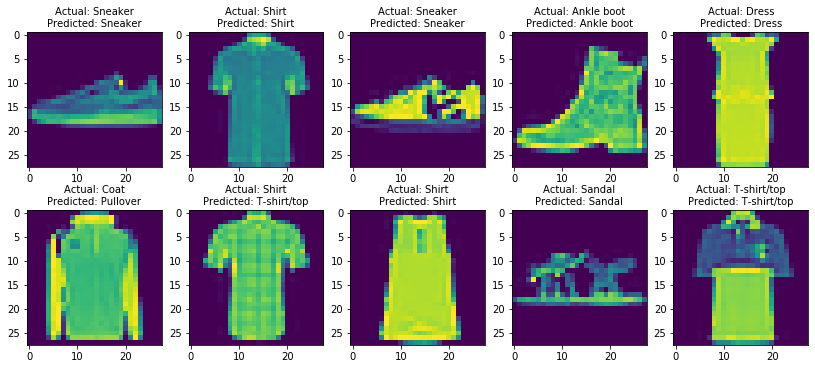

In [113]:
sample_test_data = test_images[580:590]
sample_test_labels = test_labels[580:590]
sample_test_data_processed = np.expand_dims(sample_test_data / 255., axis=3)
data = json.dumps({"signature_name": "serving_default", 
                   "instances": sample_test_data_processed.tolist()})

HEADERS = {'content-type': 'application/json'}
MODEL1_API_URL = 'http://localhost:8501/v1/models/fashion_model_serving/versions/1:predict'

json_response = requests.post(MODEL1_API_URL, data=data, headers=HEADERS)
predictions = json.loads(json_response.text)['predictions']
predictions = np.argmax(np.array(predictions), axis=1)
prediction_labels = [class_names[p] for p in predictions]

fig, ax = plt.subplots(2, 5, figsize=(14, 6))
for idx, img in enumerate(sample_test_data):
    rowidx = idx // 5
    colidx = idx % 5
    ax[rowidx, colidx].imshow(img)
    ax[rowidx, colidx].set_title('Actual: {}\nPredicted: {}'.format(class_names[sample_test_labels[idx]], 
                                                                    prediction_labels[idx]), fontsize=10)

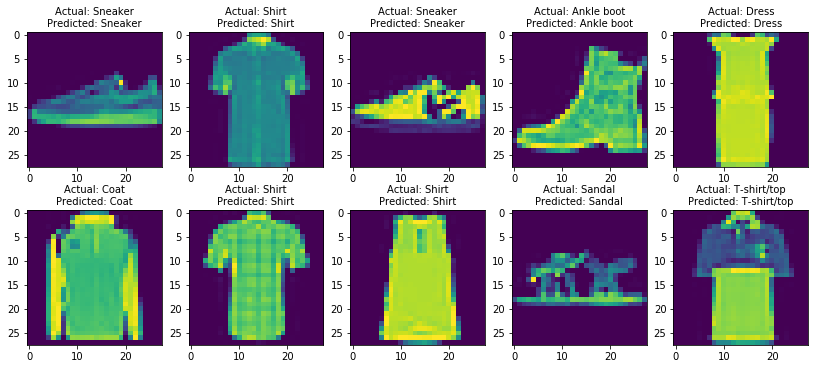

In [114]:
def resize_image_array(img, img_size_dims):
    img = cv2.resize(img, dsize=img_size_dims, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

sample_test_data = test_images[580:590]
sample_test_labels = test_labels[580:590]
IMG_DIMS = (32, 32)
sample_test_data_processed = (np.array([resize_image_array(img, 
                                                           img_size_dims=IMG_DIMS) 
                                            for img in np.stack([sample_test_data]*3, 
                                                                axis=-1)])) / 255.
data = json.dumps({"signature_name": "serving_default", 
                   "instances": sample_test_data_processed.tolist()})

HEADERS = {'content-type': 'application/json'}
MODEL2_API_URL = 'http://localhost:8501/v1/models/fashion_model_serving/versions/2:predict'

json_response = requests.post(MODEL2_API_URL, data=data, headers=HEADERS)
predictions = json.loads(json_response.text)['predictions']
predictions = np.argmax(np.array(predictions), axis=1)
prediction_labels = [class_names[p] for p in predictions]

fig, ax = plt.subplots(2, 5, figsize=(14, 6))
for idx, img in enumerate(sample_test_data):
    rowidx = idx // 5
    colidx = idx % 5
    ax[rowidx, colidx].imshow(img)
    ax[rowidx, colidx].set_title('Actual: {}\nPredicted: {}'.format(class_names[sample_test_labels[idx]], 
                                                                    prediction_labels[idx]), fontsize=10)

## Model Warmups

While productionizing and serving models, an important thing to remember is that the TensorFlow runtime has components that are lazily initialized, which can cause high latency for the first request(s) sent to a model after it is loaded. This latency can be several orders of magnitude higher than that of a single inference request. Hence it is good to warmup the models by sending a few sample records as an initial request after loading the model. You can do this at model load time by checking out the [following documentation](https://www.tensorflow.org/tfx/serving/saved_model_warmup).

Here, we will follow a simple approach of sending a sample request to each of our models to warm it up after it is loaded. For this, we save some sample data in a file which we can load and use later for warming up our models as showcased in the following code.

In [115]:
np.save('serve_warmup_data.npy', sample_test_data)

def warmup_model1_serve(warmup_data):
    warmup_data_processed = np.expand_dims(warmup_data / 255., axis=3)
    data = json.dumps({"signature_name": "serving_default", 
                       "instances": warmup_data_processed.tolist()})

    HEADERS = {'content-type': 'application/json'}
    MODEL1_API_URL = 'http://localhost:8501/v1/models/fashion_model_serving/versions/1:predict'

    json_response = requests.post(MODEL1_API_URL, data=data, headers=HEADERS)
    predictions = json.loads(json_response.text)['predictions']
    print('Model 1 warmup complete')
    
def warmup_model2_serve(warmup_data, img_dims=(32, 32)):
    warmup_data_processed = (np.array([resize_image_array(img, 
                                                          img_size_dims=img_dims) 
                                            for img in np.stack([warmup_data]*3, 
                                                                axis=-1)])) / 255.
    data = json.dumps({"signature_name": "serving_default", 
                       "instances": warmup_data_processed.tolist()})

    HEADERS = {'content-type': 'application/json'}
    MODEL2_API_URL = 'http://localhost:8501/v1/models/fashion_model_serving/versions/2:predict'

    json_response = requests.post(MODEL2_API_URL, data=data, headers=HEADERS)
    predictions = json.loads(json_response.text)['predictions']
    print('Model 2 warmup complete')
    
warmup_data = np.load('serve_warmup_data.npy')
warmup_model1_serve(warmup_data)
warmup_model2_serve(warmup_data)

Model 1 warmup complete
Model 2 warmup complete


## Benchmarking Model Serving Requests

In [116]:
%%time

sample_test_data = test_images
sample_test_labels = test_labels
sample_test_data_processed = np.expand_dims(sample_test_data / 255., axis=3)
data = json.dumps({"signature_name": "serving_default", 
                   "instances": sample_test_data_processed.tolist()})

HEADERS = {'content-type': 'application/json'}
MODEL1_API_URL = 'http://localhost:8501/v1/models/fashion_model_serving/versions/1:predict'

json_response = requests.post(MODEL1_API_URL, data=data, headers=HEADERS)
predictions = json.loads(json_response.text)['predictions']
predictions = np.argmax(np.array(predictions), axis=1)
prediction_labels = [class_names[p] for p in predictions]
len(prediction_labels)

CPU times: user 7.64 s, sys: 612 ms, total: 8.26 s
Wall time: 9.76 s


10000

In [122]:
%%time

sample_test_data = test_images
sample_test_labels = test_labels
IMG_DIMS = (32, 32)
sample_test_data_processed = (np.array([resize_image_array(img, 
                                                           img_size_dims=IMG_DIMS) 
                                            for img in np.stack([sample_test_data]*3, 
                                                                axis=-1)])) / 255.
data = json.dumps({"signature_name": "serving_default", 
                   "instances": sample_test_data_processed.tolist()})

HEADERS = {'content-type': 'application/json'}
MODEL2_API_URL = 'http://localhost:8501/v1/models/fashion_model_serving/versions/2:predict'

json_response = requests.post(MODEL2_API_URL, data=data, headers=HEADERS)
predictions = json.loads(json_response.text)['predictions']
predictions = np.argmax(np.array(predictions), axis=1)
prediction_labels = [class_names[p] for p in predictions]
len(prediction_labels)

CPU times: user 21.6 s, sys: 1.38 s, total: 23 s
Wall time: 36.4 s


10000

# Serving models with GPU Inference

In this section, we will show how to serve our saved models using TensorFlow serving leveraging our GPU. The idea is, if you have a GPU, use it! We will leverage Docker to setup our TensorFlow Serving system.

## Pulling TF Serving GPU image

Assuming you have docker installed in your system or on the cloud. You can using the following code to pull in the latest version of TF Serving on GPUs

In [146]:
!docker pull tensorflow/serving:latest-gpu

latest-gpu: Pulling from tensorflow/serving
Digest: sha256:fd54edb56a7bc72ea0606ed03b7de7d3cfb8a2143e797187555a78b37ff7c49a
Status: Image is up to date for tensorflow/serving:latest-gpu
docker.io/tensorflow/serving:latest-gpu


In [147]:
!docker images

REPOSITORY                     TAG                 IMAGE ID            CREATED             SIZE
nvidia/cuda                    9.0-base            1443caa429f9        3 weeks ago         137MB
tensorflow/serving             latest-gpu          b247542eae94        2 months ago        2.42GB
gcr.io/inverting-proxy/agent   <none>              81311f835221        4 months ago        856MB


## Start Serving Models with Docker TensorFlow Serving GPU

We are now ready to start serving models with TF Serving. We will do that by running the docker image we just downloaded. You can do it directly from Jupyter Notebooks also using the following code. In practice it is better to run it from the terminal.

In [148]:
%%bash --bg 
docker run --runtime=nvidia -p 8501:8501 \
  --mount type=bind,source=/home/jupyter/tensorflow_serving/tf_saved_models,target=/home/jupyter/tensorflow_serving/tf_saved_models \
  --mount type=bind,source=/home/jupyter/tensorflow_serving/models.conf,target=/home/jupyter/tensorflow_serving/models.conf \
  -t tensorflow/serving:latest-gpu --model_config_file=/home/jupyter/tensorflow_serving/models.conf

In [149]:
!docker ps -all

CONTAINER ID        IMAGE                           COMMAND                  CREATED             STATUS              PORTS                              NAMES
7d4b091ccefa        tensorflow/serving:latest-gpu   "/usr/bin/tf_serving…"   4 seconds ago       Up 2 seconds        8500/tcp, 0.0.0.0:8501->8501/tcp   eager_stallman


In [150]:
!docker logs 7d4b091ccefa | tail -n 15

2019-09-19 08:35:10.034464: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-09-19 08:35:10.034829: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-09-19 08:35:10.035158: I external/org_tensorflow/tensorflow/core/common_runtime/gpu/gpu_device.cc:1326] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14099 MB memory) -> physical GPU (device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5)
2019-09-19 08:35:10.804575: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2019-09-19 08:35:10.957787: I external/org_tensorflow/tensorflow/cc/saved_model/loader.c

## Model Warmup

We can leverage our previously implemented code to warmup our models. Here we will focus more on our complex 2nd CNN model so we warmup Model 2.

In [153]:
warmup_data = np.load('serve_warmup_data.npy')
warmup_model2_serve(warmup_data)

Model 2 warmup complete


## Benchmarking Model Inference Requests

Here we will look at some basic model inference requests and benchmark the serving times

### Serving one request of 10000 images

In [155]:
%%time

sample_test_data = test_images
sample_test_labels = test_labels
IMG_DIMS = (32, 32)
sample_test_data_processed = (np.array([resize_image_array(img, 
                                                           img_size_dims=IMG_DIMS) 
                                            for img in np.stack([sample_test_data]*3, 
                                                                axis=-1)])) / 255.
data = json.dumps({"signature_name": "serving_default", 
                   "instances": sample_test_data_processed.tolist()})

HEADERS = {'content-type': 'application/json'}
MODEL2_API_URL = 'http://localhost:8501/v1/models/fashion_model_serving/versions/2:predict'

json_response = requests.post(MODEL2_API_URL, data=data, headers=HEADERS)
predictions = json.loads(json_response.text)['predictions']
predictions = np.argmax(np.array(predictions), axis=1)
prediction_labels = [class_names[p] for p in predictions]
len(prediction_labels)

CPU times: user 23.5 s, sys: 1.87 s, total: 25.3 s
Wall time: 31.3 s


10000

### Serving 10000 inference requests each on a single image

In [156]:
def predict_apparel_model2_serving(img, img_dims=(32,32), label_map=class_names):
    
    sample_img_processed = (np.array([resize_image_array(img, 
                                                         img_size_dims=img_dims) 
                                                for img in np.stack([[img]]*3, 
                                                                    axis=-1)])) / 255.
    data = json.dumps({"signature_name": "serving_default", 
                       "instances": sample_img_processed.tolist()})
    
    HEADERS = {'content-type': 'application/json'}
    MODEL2_API_URL = 'http://localhost:8501/v1/models/fashion_model_serving/versions/2:predict'
    json_response = requests.post(MODEL2_API_URL, data=data, headers=HEADERS)
    prediction = json.loads(json_response.text)['predictions']
    prediction = np.argmax(np.array(prediction), axis=1)[0]
    return label_map[prediction]

In [157]:
%%time

pred_labels = []
for img in tqdm(test_images):
    pred_label = predict_apparel_model2_serving(img)
    pred_labels.append(img)
len(pred_labels)

100%|██████████| 10000/10000 [01:55<00:00, 86.56it/s]

CPU times: user 39.1 s, sys: 2.2 s, total: 41.3 s
Wall time: 1min 55s


10000

In [158]:
INPUT_SHAPE_RN = (32, 32, 3)
model2 = create_cnn_architecture_model2(input_shape=INPUT_SHAPE_RN)
model2.load_weights('./model_weights/cnn_model2_wt.h5')

def predict_apparel_model2_regular(img, img_dims=(32,32), label_map=class_names):
    
    sample_img_processed = (np.array([resize_image_array(img, 
                                                         img_size_dims=img_dims) 
                                                for img in np.stack([[img]]*3, 
                                                                    axis=-1)])) / 255.
    prediction = model2.predict(sample_img_processed)
    prediction = np.argmax(np.array(prediction), axis=1)[0]
    return label_map[prediction]

/usr/local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [159]:
%%time

pred_labels = []
for img in tqdm(test_images):
    pred_label = predict_apparel_model2_regular(img)
    pred_labels.append(img)
len(pred_labels)

100%|██████████| 10000/10000 [03:04<00:00, 54.12it/s]

CPU times: user 3min 8s, sys: 17.2 s, total: 3min 25s
Wall time: 3min 4s


10000

# Bonus: Building an Apparel Classifier API with Flask & TensorFlow Serving

While TF Serving is extremely useful and provides us with a high-performance system to serve inference requests. Considering an end-to-end perspective, you might have noticed that model serving is not just dumping some data as requests to the server. We need to access the image data, pre-process it and then send it in an appropriate format to TF Serving. Also once we get back the response, we need to access the class probabilities, get the class with the maximum probability and then get the corresponding apparel class label.

The best way to put all these steps together is to leverage a robust framework like Flask to build a web service / API on top of TF Serving to accept images from the real-world, perform necessary pre-processing, call TF Serving, post-process the response and then send the final JSON response to the end-user. Do note that we can even dockerize and deploy the Flask API on Kubernetes or use a WSGI server like Gunicorn to scale and improve performance.

![](https://miro.medium.com/max/2344/1*5voGRt_Wk_JCtExZY0_P9g.png)

## Start Docker Container for TF Serving

Check and restart the docker container for TF Serving if it’s not already up and running.

In [4]:
!docker start 7d4b091ccefa
!docker ps -all

7d4b091ccefa
CONTAINER ID        IMAGE                           COMMAND                  CREATED             STATUS                  PORTS                              NAMES
7d4b091ccefa        tensorflow/serving:latest-gpu   "/usr/bin/tf_serving…"   About an hour ago   Up Less than a second   8500/tcp, 0.0.0.0:8501->8501/tcp   eager_stallman


In [5]:
!docker logs 7d4b091ccefa | tail -n 15

2019-09-19 09:54:37.203773: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-09-19 09:54:37.204142: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-09-19 09:54:37.204498: I external/org_tensorflow/tensorflow/core/common_runtime/gpu/gpu_device.cc:1326] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14099 MB memory) -> physical GPU (device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5)
2019-09-19 09:54:37.978870: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2019-09-19 09:54:38.131329: I external/org_tensorflow/tensorflow/cc/saved_model/loader.c

## Create API with Flask

We will start by creating our own apparel API leveraging Flask, you will find the code files in my [GitHub repository](https://github.com/dipanjanS/data_science_for_all/tree/master/gde_tf_serve_vision/tensorflow_serving) in the file named [__`app.py`__](https://github.com/dipanjanS/data_science_for_all/blob/master/gde_tf_serve_vision/tensorflow_serving/app.py)

## Start our Apparel Classifier Web Service

Now, we need to start our web service. In production, it is recommended you do NOT use the default web server provided by Flask but a better production-ready WSGI server, just like Gunicorn. We start our web service using the following command from the terminal.

![](https://miro.medium.com/max/1273/1*m_cdBBSFmF1mHc0bJsLdzQ.png)

## Test if API is Live

In [53]:
r = requests.get('http://0.0.0.0:5000/apparel_classifier/api/v1/liveness')
r.status_code, r.text

(200, 'API Live!')

## Load a real-world Image

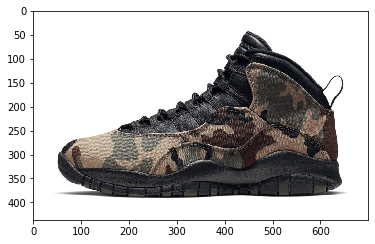

In [54]:
plt.imshow(cv2.cvtColor(cv2.imread('sneaker.jpg'), cv2.COLOR_BGR2RGB))

## Serve Sample Apparel Classification with Web Service

In [55]:
import base64
import requests 

with open('sneaker.jpg', "rb") as imageFile:
    img_b64enc = base64.b64encode(imageFile.read())
    data = {'b64_img': img_b64enc}

API_URL = 'http://0.0.0.0:5000/apparel_classifier/api/v1/model2_predict'
# sending post request and saving response as response object
r = requests.post(url=API_URL, data=data)
r.json()

{'apparel_type': 'Sneaker'}

## Benchmark our Web Service

In [58]:
%%time

responses = []
for i in tqdm(range(10000)):
    API_URL = 'http://0.0.0.0:5000/apparel_classifier/api/v1/model2_predict'
    # sending post request and saving response as response object
    r = requests.post(url=API_URL, data=data)
    responses.append(r.json())
len(responses)

100%|██████████| 10000/10000 [05:26<00:00, 30.66it/s]

CPU times: user 1min, sys: 3.17 s, total: 1min 4s
Wall time: 5min 26s


10000

In [61]:
print('Inference time per image: {} ms'.format((326 / 10000) * 1000)) 

Inference time per image: 32.599999999999994 ms
